The downstream study based on sklearn framework.
====================
Study of the seed selection
-----------------------------

At first I want to look at the input data and then prepare baseline for further studies. 
I would like to use fisher and BDT as a baseline clasifiers. And then more sophisticated models (deep NN) will be used. 

In [1]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

Welcome to JupyROOT 6.07/07


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [2]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [3]:
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Print the features
-------------------------

In [4]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06
mean,2.151541e+00,2.597007e+04,2.154239e+03,1.778696e+01,2.583371e+00,1.116850e+01,2.711442e+00,-6.605598e+00,3.993058e-03,-7.695354e-04
std,1.450411e+00,3.971438e+06,1.839172e+05,4.672981e+00,4.624577e+00,1.080491e+00,6.953988e+02,5.627308e+02,3.198594e-01,7.319783e-02
min,2.503011e-04,1.112569e+03,1.762072e+00,8.000000e+00,0.000000e+00,8.000000e+00,-2.491031e+03,-2.277240e+03,-1.284890e+00,-1.225459e+00
25%,1.053873e+00,3.014385e+03,9.318066e+02,1.300000e+01,0.000000e+00,1.100000e+01,-3.955872e+02,-2.221584e+02,-1.793712e-01,-3.197528e-02
50%,1.714204e+00,5.749199e+03,1.123466e+03,1.900000e+01,0.000000e+00,1.200000e+01,-4.058384e+00,-4.284824e+00,4.472219e-03,-4.200478e-04
75%,2.949078e+00,1.318862e+04,1.370916e+03,2.200000e+01,4.000000e+00,1.200000e+01,3.996642e+02,2.098940e+02,1.902165e-01,3.053767e-02
max,8.999829e+00,4.048456e+09,1.676033e+08,3.200000e+01,2.300000e+01,1.200000e+01,2.505840e+03,2.217239e+03,1.358254e+00,5.944709e-01


In [5]:
def print_features_histograms(features):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(data[feature], [1, 99])
        ax.hist(data.ix[data.is_true_seed.values == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(data.ix[data.is_true_seed.values == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

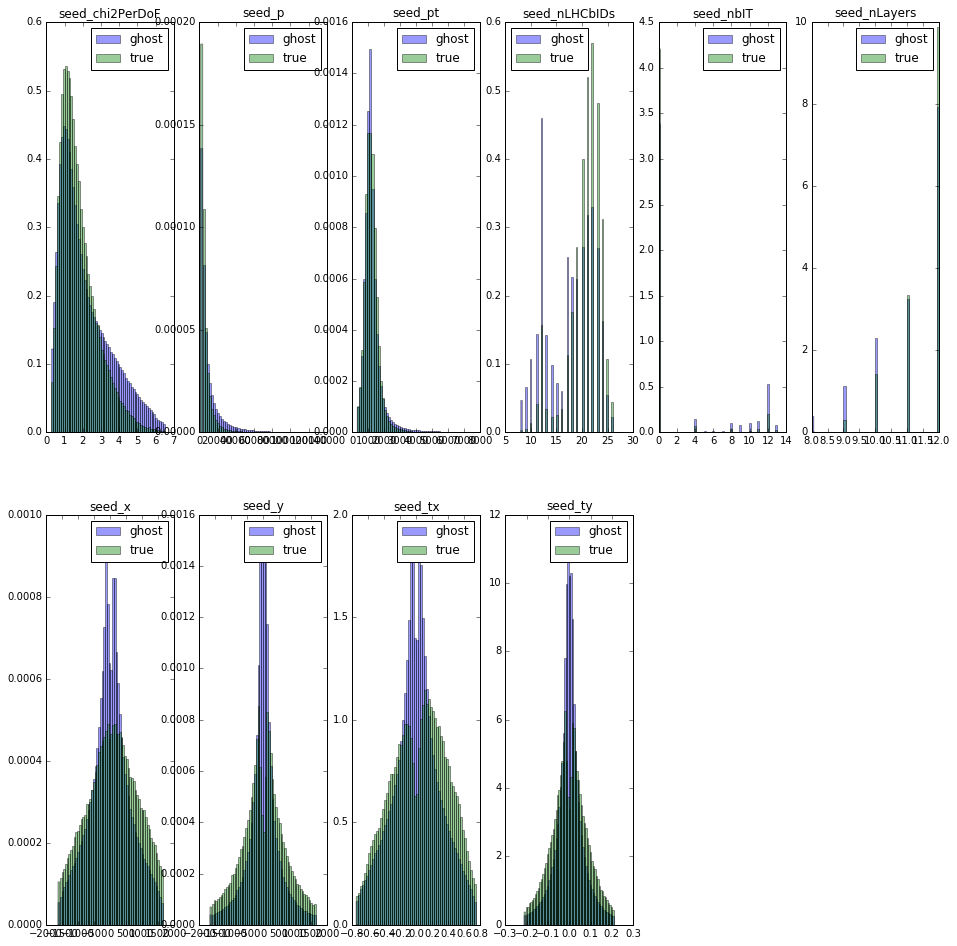

In [6]:
print_features_histograms(features)

In [7]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


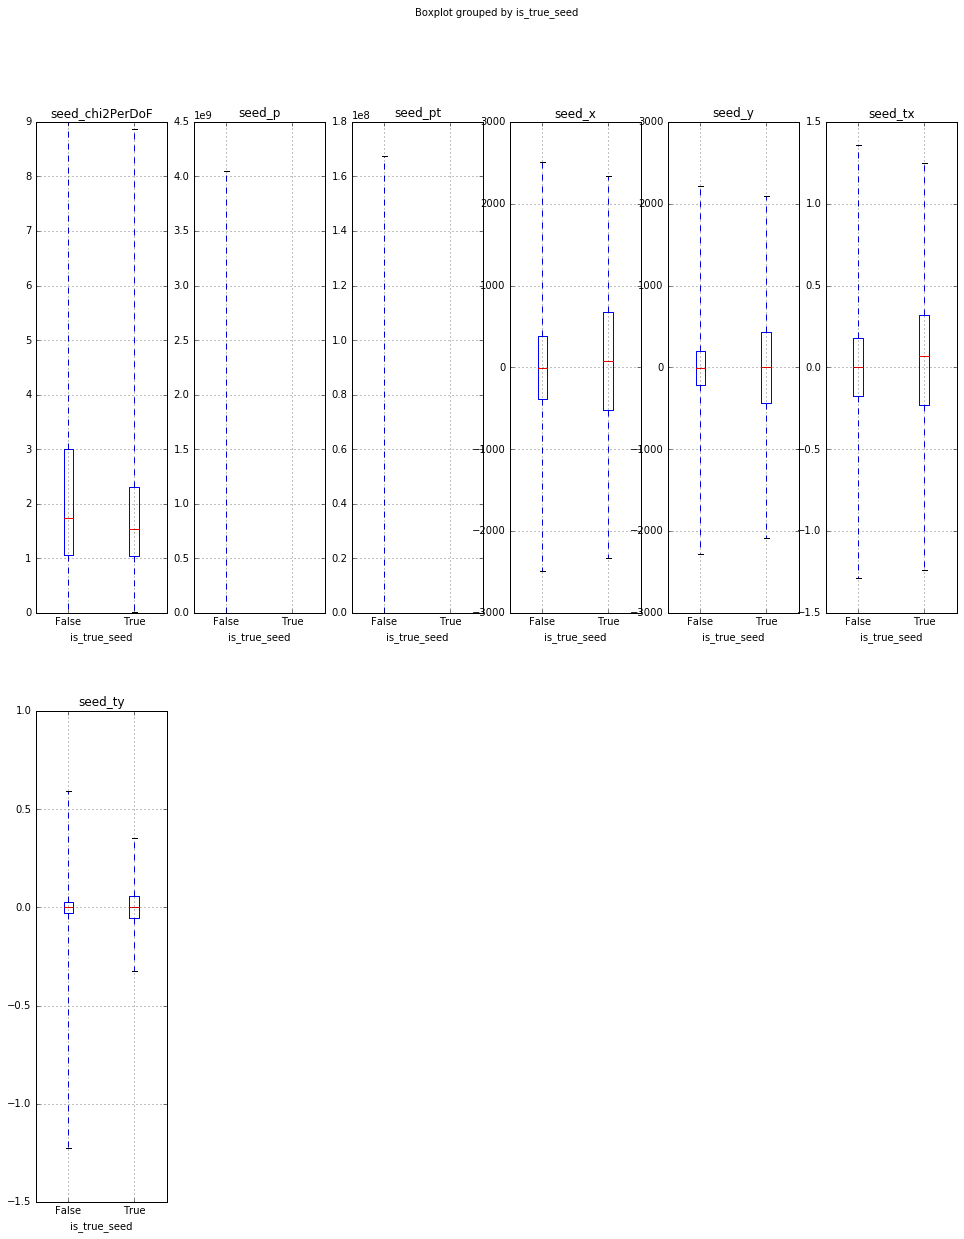

In [8]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

Training of the baselines's clasifiers
=======================

Split data into train and validation sets
----------------------

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

At first try kNN. 
---------------
As a k I choose arbitrary value equal to 6. This value can be tuned via grid search but it is pointless. 
I am not using any of the feature engenering. I just want to create very low level baseline.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [11]:
print "ROC AUC score"
roc_auc_score(testY, knn.predict_proba(testX)[:, 1])

0.68991415713489046

ROC AUC score


Cross Validation score

In [12]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(knn,
                                          testX, testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
"Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

'Accuracy: 0.65400 (+/- 0.00106)'

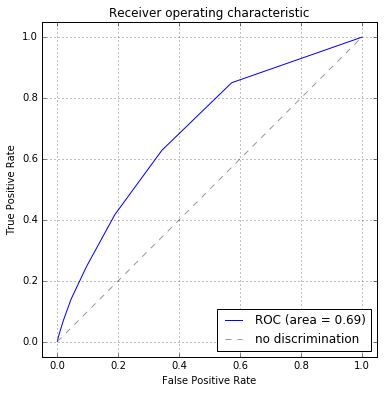

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. For the very basic algorithm like kNN we can only play with:
* k - number of neighbours. 
  * The cosidered range of k is between 5 and 50
* metrics. Possible choices see [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)
* We can also look at the different optimalization algorithms such as BallTree or KDTree. But it should has no impact on classiffier performance

Right now I switched off grid optimalization it is not possible to run it on my PC. 
----------------------

 from sklearn import grid_search
from sklearn.metrics import classification_report
knn_grid_params = {"n_neighbors": [x  for x in range(19,51) if x % 10  == 0],
                  "metric": ['minkowski',  'canberra']}
clf = grid_search.GridSearchCV(knn,
                               knn_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=8);
clf.fit(trainX, trainY);

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = testY, clf.predict(testX)
print(classification_report(y_true, y_pred))
print()

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the BDT. It is one of the best classifier, that can be used as a baseline. 
I just need to tune 3 parameters. 
* Spliting criteria
* tree depth
* number of the trees

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8)
gb.fit(trainX,trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=13, subsample=0.8, verbose=0,
              warm_start=False)

In [17]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

0.79317333112259436

ROC AUC score


In [18]:
scores = cross_validation.cross_val_score(gb,
                                          testX, testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.78463 (+/- 0.00200)


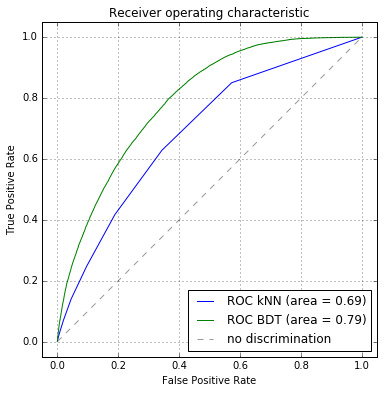

In [19]:
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC kNN (area = %0.2f)'%(roc_auc))
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

In [20]:
def print_feature_importance(model, features):
    importances = model.feature_importances_
    std = numpy.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = numpy.argsort(importances)[::-1]
    features_names =  list(features.columns.values)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation=70)
    plt.xlim([-1, features.shape[1]])
    plt.show()

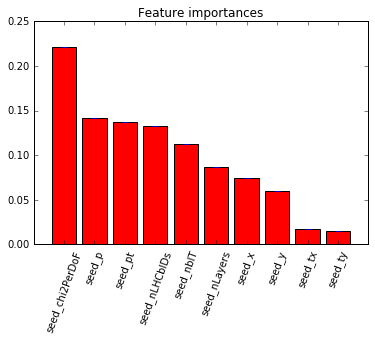

Feature ranking:
1. feature seed_chi2PerDoF (0.220697)
2. feature seed_p (0.141999)
3. feature seed_pt (0.136698)
4. feature seed_nLHCbIDs (0.133255)
5. feature seed_nbIT (0.113079)
6. feature seed_nLayers (0.086767)
7. feature seed_x (0.074853)
8. feature seed_y (0.059471)
9. feature seed_tx (0.017690)
10. feature seed_ty (0.015491)


In [21]:
print_feature_importance(gb, features)

Feature Engenering
======================
Add transformated features
-------------------
At the begining let's try some very basic feature transformation. For instance log the momentums and take abs of simetrical distributed features. 

In [22]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["log_p"]= numpy.log(data['seed_p'])
    out["log_pt"]= numpy.log(data['seed_pt'])
    return out

In [23]:
new_data = basic_transforamtion(data)
new_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,log_p,log_pt
0,1.213708,2543.471925,1187.267858,25.0,0.0,12.0,-1263.157617,-517.249191,-0.524220,-0.061572,1263.157617,517.249191,0.524220,0.061572,7.841285,7.079410
1,1.346112,2781.485771,1204.396954,25.0,0.0,12.0,1264.522435,-99.363473,0.480288,-0.009081,1264.522435,99.363473,0.480288,0.009081,7.930741,7.093734
2,1.627632,4769.446536,1708.511389,25.0,0.0,12.0,-1521.093160,-196.064807,-0.382802,-0.025975,1521.093160,196.064807,0.382802,0.025975,8.469986,7.443378
3,1.789231,5202.918132,1823.936187,25.0,0.0,12.0,-1563.145597,-483.850246,-0.369674,-0.058753,1563.145597,483.850246,0.369674,0.058753,8.556975,7.508752
4,1.269238,2300.960611,1252.585447,24.0,0.0,12.0,-1641.727752,-411.084316,-0.646627,-0.054980,1641.727752,411.084316,0.646627,0.054980,7.741082,7.132965


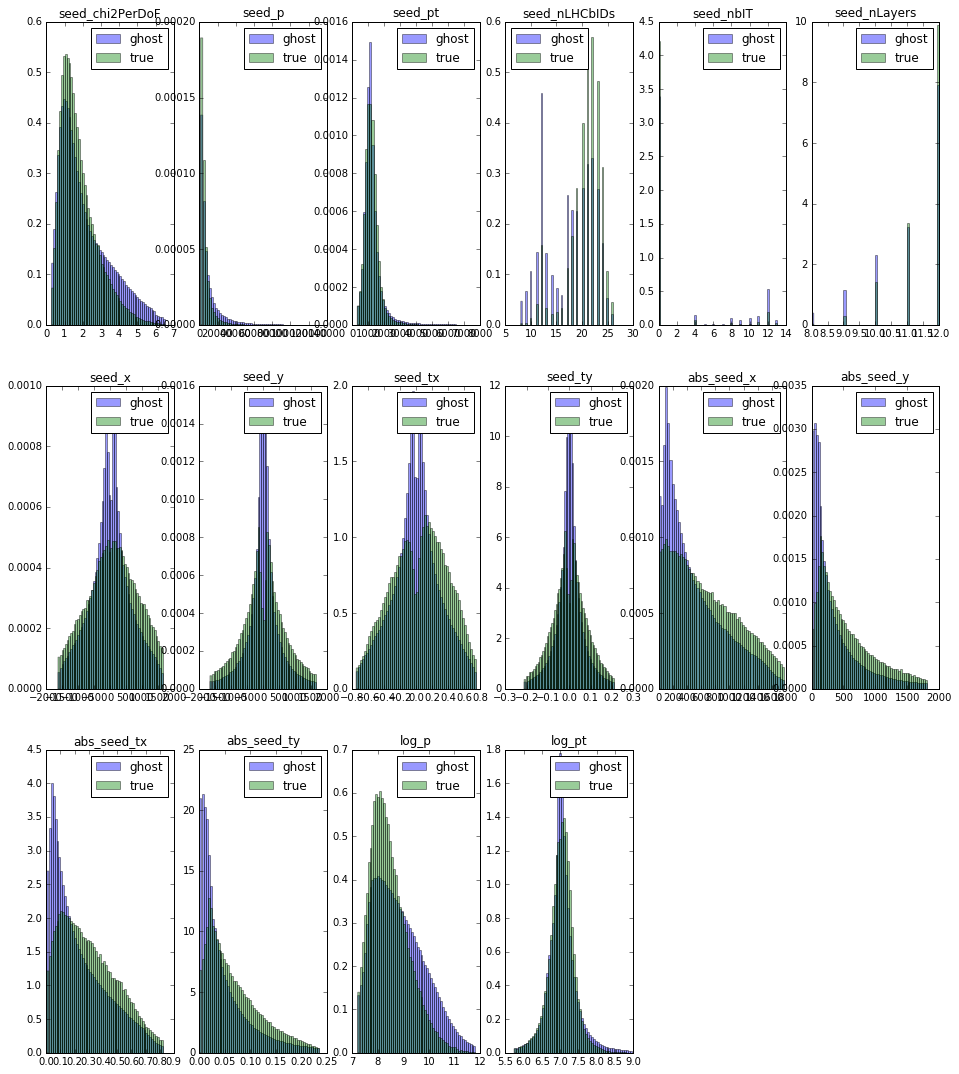

In [24]:
print_features_histograms(new_features)

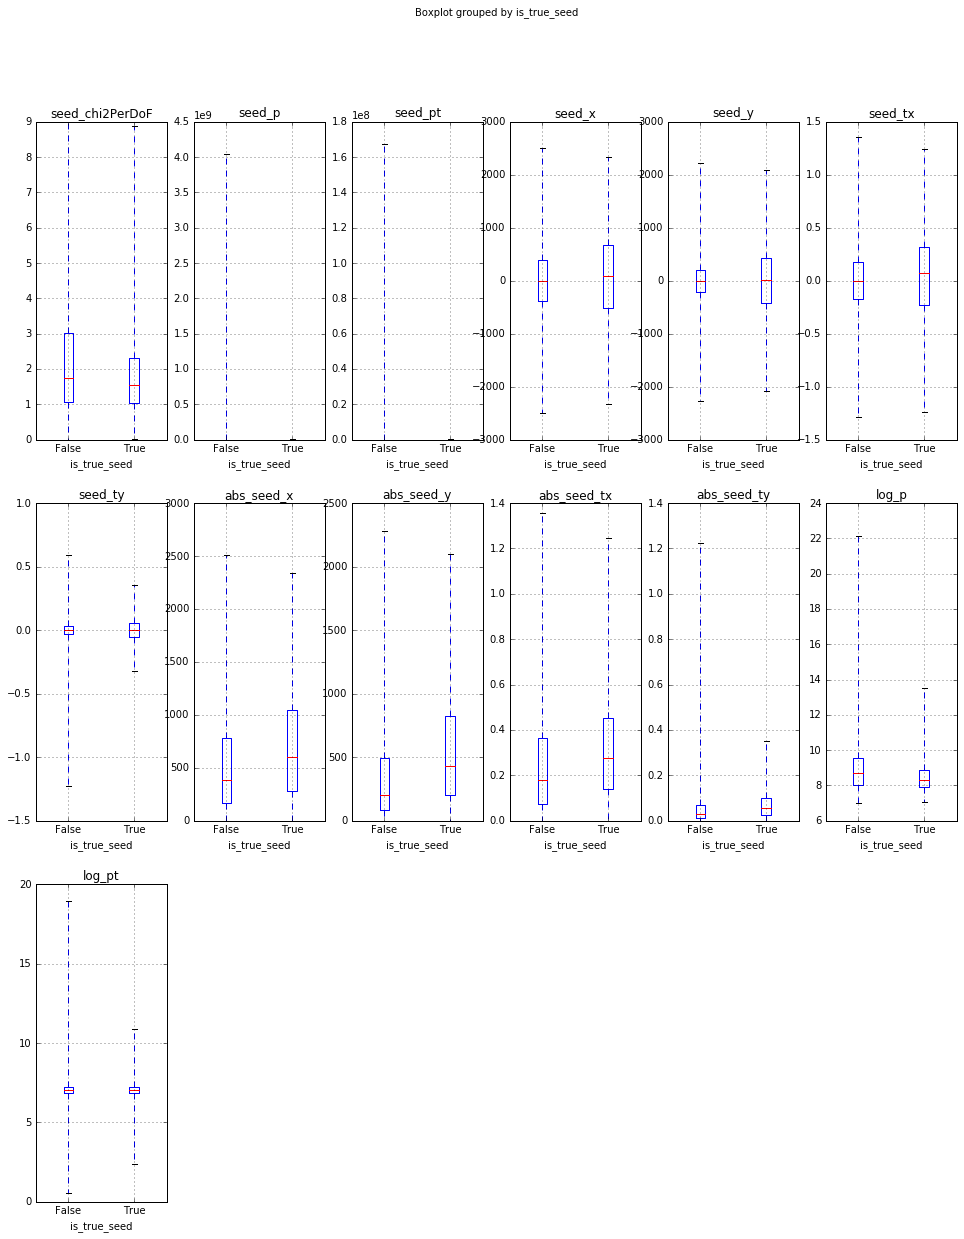

In [25]:
fig = plt.figure(figsize=(16,  20))
new_real_data_features = new_features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(new_real_data_features)

Try KNN for the new features

In [26]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=20)
knn2.fit(new_trainX,new_trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [ ]:
print "ROC AUC score"
roc_auc_score(new_testY, knn2.predict_proba(new_testX)[:, 1])

In [ ]:
gb2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8)
gb2.fit(new_trainX,new_trainY)

In [ ]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

In [ ]:
print_feature_importance(gb2, new_features)

The aboveresult is very interested. The new features has almost no power. Hmmm

In [ ]:
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC kNN (area = %0.2f)'%(roc_auc))

fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))

fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT new features (area = %0.2f)'%(roc_auc))


fpr, tpr, thresholds = roc_curve(new_testY, knn2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC kNN new features (area = %0.2f)'%(roc_auc))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Try replace features into it's transforamtion
---------------------

In [ ]:
def replace_transforamtion(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [ ]:
replaced_data = replace_transforamtion(data)
replaced_features = new_data.drop("is_true_seed", axis=1).astype(numpy.float64)
replaced_features.head()

In [ ]:
print_features_histograms(replaced_features)
fig = plt.figure(figsize=(16,  20))
repleaced_real_data_features = replaced_features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(repleaced_real_data_features)